In [11]:
import sys

sys.path.append("../")

In [12]:
import os
import torch
import numpy as np
import segmentation_models_pytorch as smp

from scripts.plotting import show_images
from scripts.preprocessing import RoadDataset, split_data
from torch.utils.data import DataLoader

In [13]:
ROOT_PATH = os.path.normpath(os.getcwd() + os.sep + os.pardir)
train_directory = os.path.join(ROOT_PATH, 'data', 'raw', 'training')
image_path_train, image_path_test, mask_path_train, mask_path_test = split_data(train_directory, 0.2)

In [14]:
# Get train and val dataset instances
train_dataset = RoadDataset(image_path_train, mask_path_train)
valid_dataset = RoadDataset(image_path_test, mask_path_test)

n_cpu = os.cpu_count()

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=n_cpu, persistent_workers=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=n_cpu, persistent_workers=True)

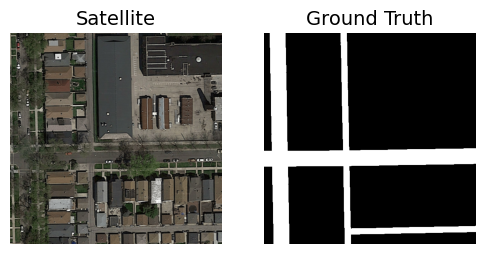

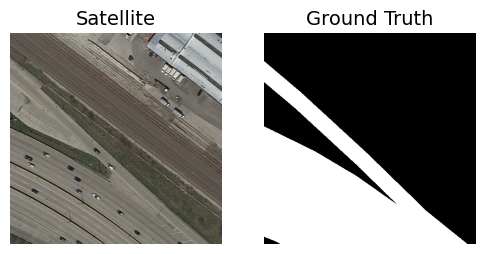

In [15]:
for i in range(2):
    img, mask = train_dataset[i]
    show_images(axis=False, satellite=img.transpose(1, 2, 0), ground_truth=mask.squeeze())

In [16]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['background', 'road']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

In [17]:
model = smp.create_model("FPN", encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHTS)
criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [18]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.float())
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss.item():.3f}')

[1,     1] loss: 0.678
[1,     2] loss: 0.619
[1,     3] loss: 0.728
[1,     4] loss: 0.632
[1,     5] loss: 0.509
[1,     6] loss: 0.434
[1,     7] loss: 0.415
[1,     8] loss: 0.416
[1,     9] loss: 0.545
[1,    10] loss: 0.400
[1,    11] loss: 0.389
[1,    12] loss: 0.361
[1,    13] loss: 0.330
[1,    14] loss: 0.410
[1,    15] loss: 0.318
[1,    16] loss: 0.442
[1,    17] loss: 0.425
[1,    18] loss: 0.658
[1,    19] loss: 0.297
[1,    20] loss: 0.350
[2,     1] loss: 0.236
[2,     2] loss: 0.359
[2,     3] loss: 0.245
[2,     4] loss: 0.352
[2,     5] loss: 0.311
[2,     6] loss: 0.320
[2,     7] loss: 0.357
[2,     8] loss: 0.249
[2,     9] loss: 0.259
[2,    10] loss: 0.249
[2,    11] loss: 0.371
[2,    12] loss: 0.304
[2,    13] loss: 0.274
[2,    14] loss: 0.310
[2,    15] loss: 0.270
[2,    16] loss: 0.437
[2,    17] loss: 0.217
[2,    18] loss: 0.264
[2,    19] loss: 0.341
[2,    20] loss: 0.279
[3,     1] loss: 0.211
[3,     2] loss: 0.278
[3,     3] loss: 0.250
[3,     4] 

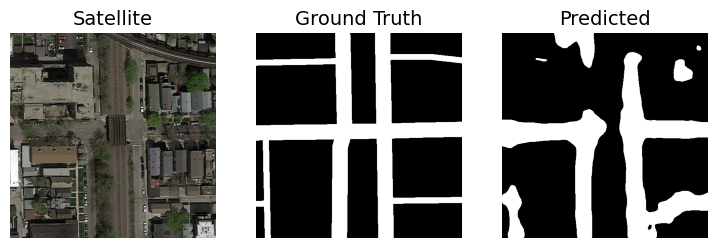

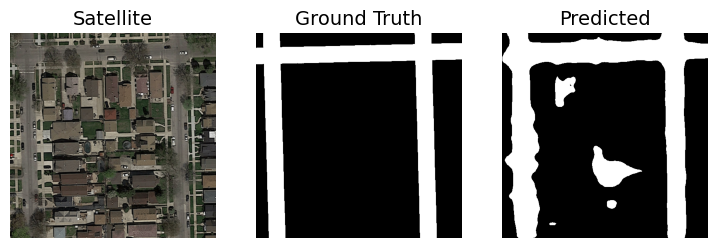

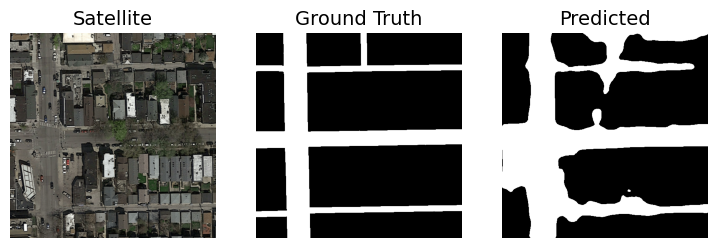

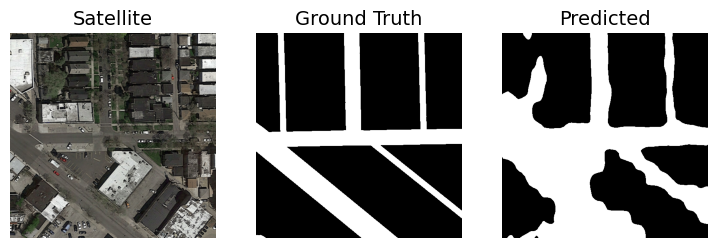

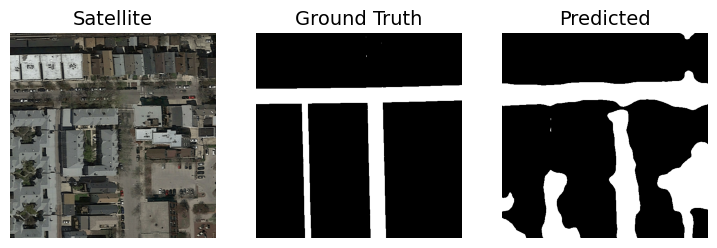

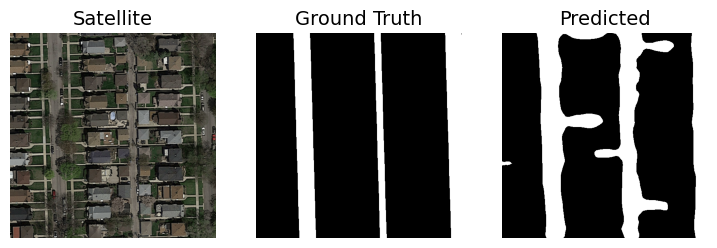

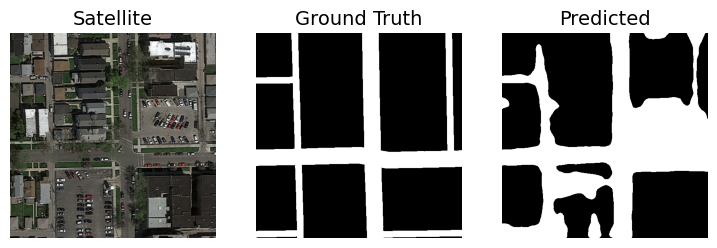

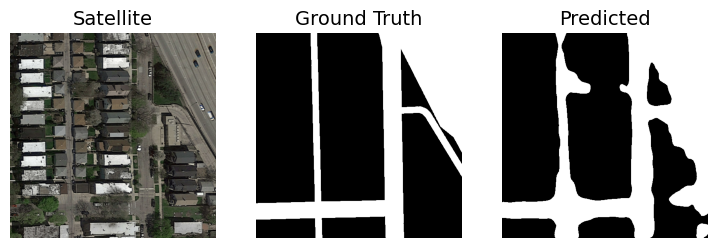

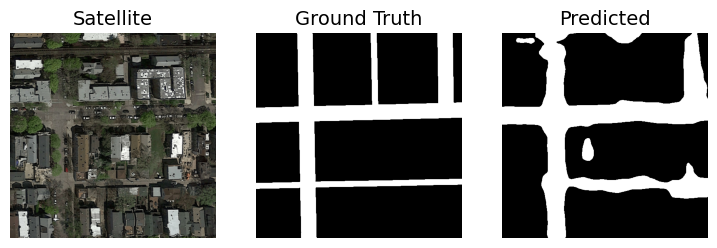

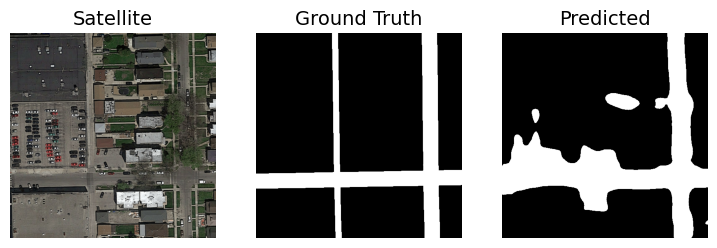

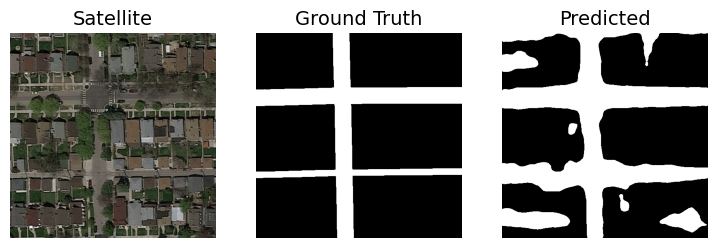

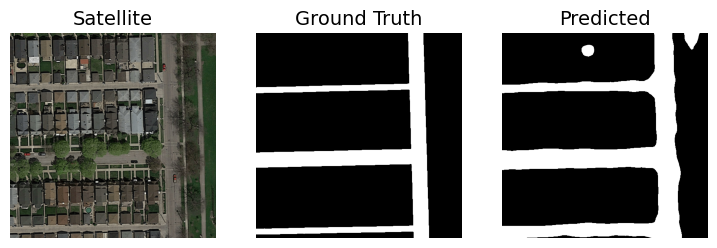

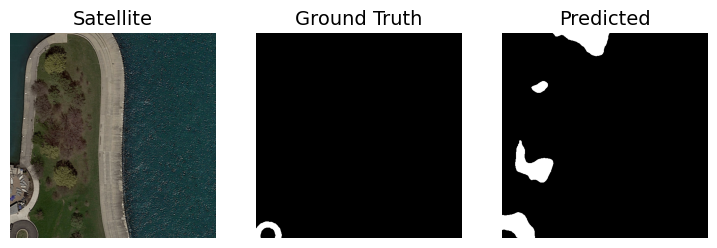

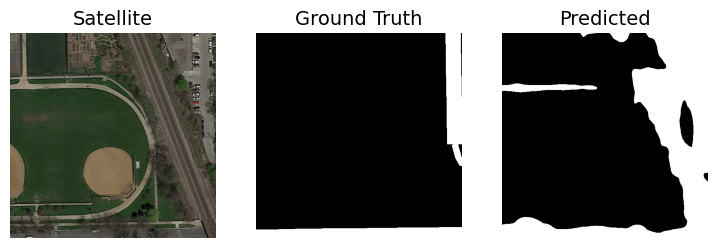

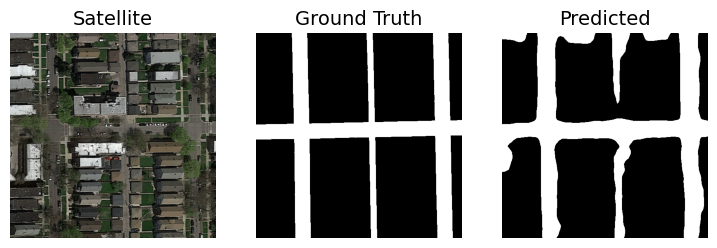

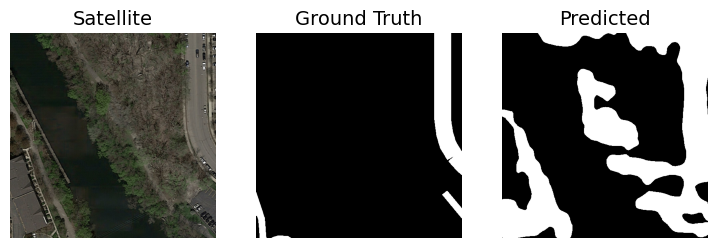

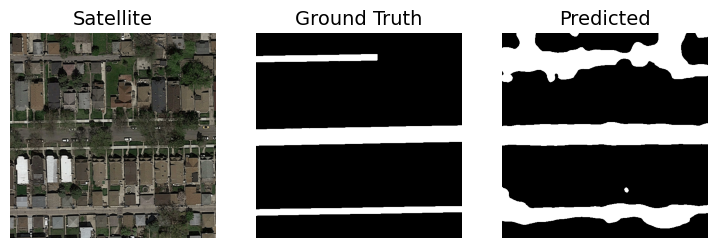

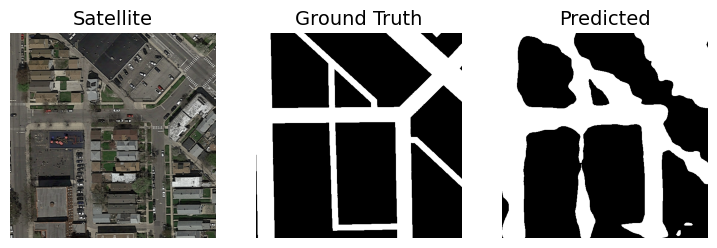

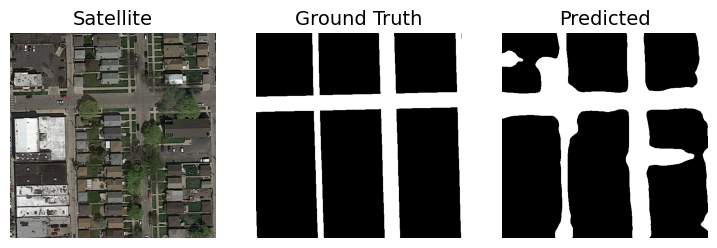

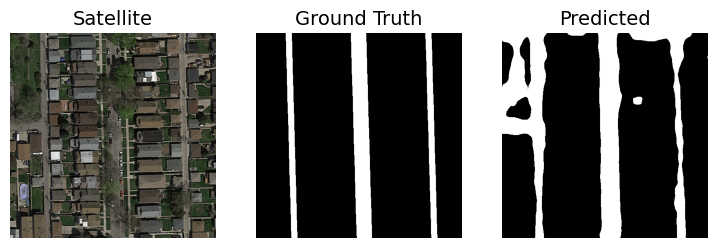

In [19]:
for images, ground_truths in iter(valid_loader):
    with torch.no_grad():
        model.eval()
        logits = model(images.float())
    predicted = logits.sigmoid()
    
    for image, ground_truth, predicted in zip(images, ground_truths, predicted):
        
        image = image.numpy().transpose(1, 2, 0)
        ground_truth = ground_truth.numpy().squeeze()
        predicted = np.where(predicted.numpy().squeeze() >= 0.5, 1, 0)
        
        show_images(axis=False, satellite=image, ground_truth=ground_truth, predicted=predicted)